<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](./data/mountain/art1131.jpg)|![](./data/forest/cdmc317.jpg)|

The problem is realively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be sometime that can expect with prototyping an image classification problem/solution at work. Get accustomed to evaluating several differnet possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D()
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to add additional fully connected layers to our model. When we removed the top layers, we removed all previous fully connected layers. In other words, we kept only the feature processing portions of our network. You can experiment with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

## Load in Data

![skimage-logo](https://scikit-image.org/_static/img/logo.png)

Check out out [`skimage`](https://scikit-image.org/) for useful functions related to processing the images. In particular checkout the documentation for `skimage.io.imread_collection` and `skimage.transform.resize`.

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from skimage import color, io
from skimage.exposure import rescale_intensity

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

## Load data

In [2]:
mountains = io.imread_collection('./data/mountain/*')
forests = io.imread_collection('./data/forest/*')

In [3]:
print('Mountain images:', len(mountains))
print('Forest images:', len(forests))

Mountain images: 374
Forest images: 328


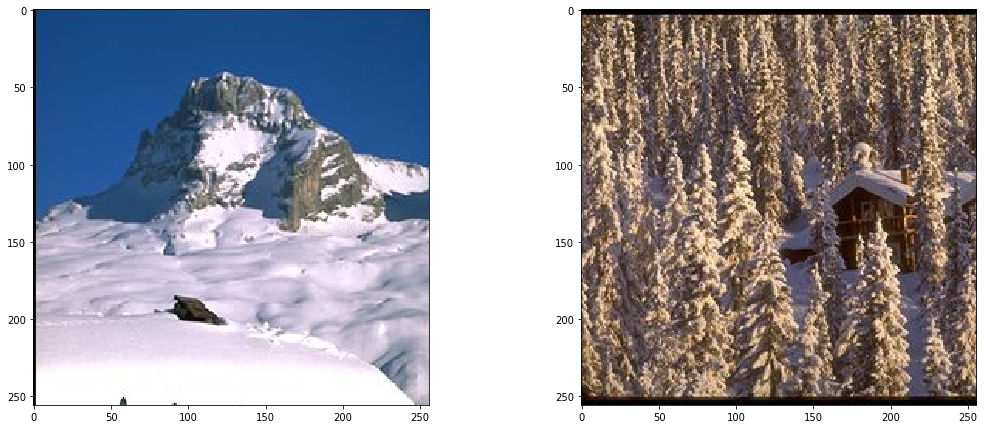

In [4]:
# Preview full color images.
fig = plt.figure(figsize=(18, 16))

plt.subplot(2, 2, 1)
plt.imshow(mountains[0]);

plt.subplot(2, 2, 2)
plt.imshow(forests[0]);

## Create grayscale image dataset

In [5]:
def to_grayscale(images):
    """
    Convert images in an iterable to grayscale.
    """
    grayscale_images = []
    for image in images:
        gs_image = rescale_intensity(color.rgb2gray(image))
        grayscale_images.append(gs_image)
    return grayscale_images

In [6]:
gs_mountains = to_grayscale(mountains)
gs_forests = to_grayscale(forests)

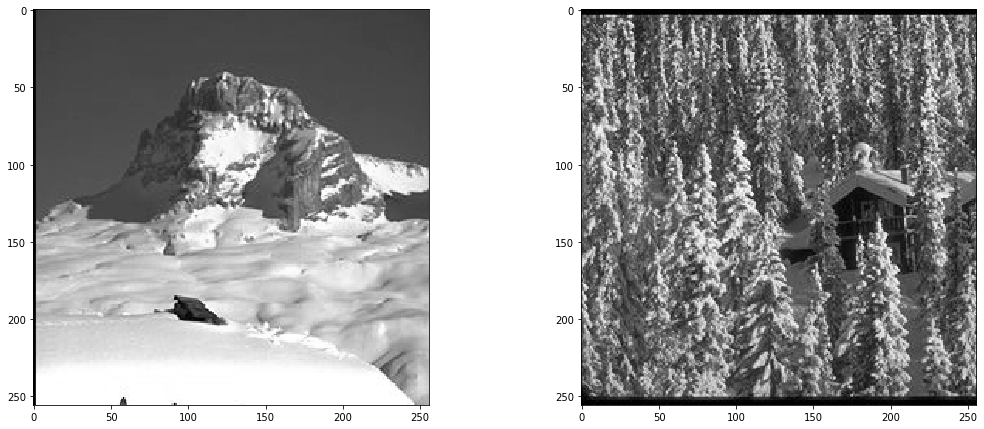

In [7]:
# Preview grayscale images
fig = plt.figure(figsize=(18, 16))

plt.subplot(2, 2, 1)
plt.imshow(gs_mountains[0], cmap="gray");

plt.subplot(2, 2, 2)
plt.imshow(gs_forests[0], cmap="gray");

## Preprocess color image data

In [8]:
mountain_list = []
for mountain in mountains:
    mountain = image.img_to_array(mountain)
    mountain = np.expand_dims(mountain, axis=0)
    mountain = preprocess_input(mountain)
    mountain_list.append(mountain)

In [9]:
forest_list = []

for forest in forests:
    forest = image.img_to_array(forest)
    forest = np.expand_dims(forest, axis=0)
    forest = preprocess_input(forest)
    forest_list.append(forest)

## Test pre-trained model

In [10]:
resnet = ResNet50(weights='imagenet', 
                  include_top=True, 
                  input_tensor=Input(shape=(256, 256, 3)))

In [11]:
mountain_predictions = []

for mountain in mountain_list:
    mountain_predictions.append(np.squeeze(resnet.predict(mountain)))

In [12]:
forest_predictions = []

for forest in forest_list:
    forest_predictions.append(np.squeeze(resnet.predict(forest)))

In [13]:
mountain_predictions = decode_predictions(np.array(mountain_predictions), top=1)

In [14]:
forest_predictions = decode_predictions(np.array(forest_predictions), top=1)

In [15]:
mountain_predictions = np.squeeze(mountain_predictions)

In [16]:
forest_predictions = np.squeeze(forest_predictions)

In [17]:
mountain_df = pd.DataFrame(mountain_predictions, 
                           columns=['code', 'description', 'confidence'])

In [18]:
forest_df = pd.DataFrame(forest_predictions, 
                         columns=['code', 'description', 'confidence'])

In [19]:
mountain_df['description'].value_counts(normalize=True)

alp              0.745989
valley           0.117647
cliff            0.064171
volcano          0.045455
mountain_tent    0.005348
ski              0.005348
seashore         0.002674
shovel           0.002674
lakeside         0.002674
promontory       0.002674
balloon          0.002674
snowplow         0.002674
Name: description, dtype: float64

In [20]:
forest_df['description'].value_counts(normalize=True)

valley               0.341463
lakeside             0.109756
park_bench           0.057927
alp                  0.051829
rapeseed             0.030488
cliff                0.027439
snowmobile           0.024390
buckeye              0.021341
maze                 0.021341
suspension_bridge    0.021341
boathouse            0.015244
picket_fence         0.015244
bison                0.015244
coral_reef           0.012195
cliff_dwelling       0.012195
pot                  0.012195
mountain_tent        0.012195
dogsled              0.012195
pole                 0.009146
worm_fence           0.009146
seashore             0.009146
greenhouse           0.009146
viaduct              0.006098
lumbermill           0.006098
megalith             0.006098
canoe                0.006098
mountain_bike        0.006098
barn                 0.006098
obelisk              0.006098
stone_wall           0.006098
                       ...   
stole                0.003049
electric_ray         0.003049
totem_pole

## Instantiate Model

In [21]:
resnet = ResNet50(weights='imagenet', include_top=False)

In [22]:
for layer in resnet.layers:
    layer.trainable = False

In [23]:
x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)

In [24]:
# Compile model.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Fit Model

In [25]:
X = np.squeeze(np.array(mountain_list + forest_list))
y = np.hstack([np.ones(len(mountain_list)), np.zeros(len(forest_list))])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [27]:
model.fit(X_train, y_train)

Train on 561 samples
561/561 [==============================] - 172s 307ms/sample - loss: 0.1719 - accuracy: 0.9323


In [30]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

In [36]:
train_preds = np.rint(train_preds).astype(int)
test_preds = np.rint(test_preds).astype(int)

In [37]:
train_accuracy = accuracy_score(train_preds, y_train)
test_accuracy = accuracy_score(test_preds, y_test)

In [38]:
print('Training accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Training accuracy: 0.9928698752228164
Test accuracy: 0.9858156028368794


# Custom CNN Model

In [28]:
# Compile Model


In [29]:
# Fit Model


# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language